In [7]:
pip install pandas numpy matplotlib seaborn psutil

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
### IMPORTS

from resource_metrics_and_visualizations import (
    add_metrics_to_predictor,
    ResourceMetrics
)
from paper_visualizations import PaperVisualizations
from integration_example import run_tte_prediction_with_metrics

Running on CPU (GPU disabled in config)

--- LOADING DATA ---
Loaded data with 39716 rows and 500 vehicles

--- CLEANING DATA ---
Data cleaned: 39716 rows remaining with 105 features

--- ENGINEERING FEATURES ---

Sample counts per variability level:
variability
high      13504
low       13106
medium    13106
Name: count, dtype: int64
Feature engineering complete. Total features: 124

--- CLEANING DATA ---
Data cleaned: 39716 rows remaining with 124 features

--- ENGINEERING FEATURES ---

Sample counts per variability level:
variability
high      13504
low       13106
medium    13106
Name: count, dtype: int64
Feature engineering complete. Total features: 124

--- ANALYZING SCENARIOS ---

Analyzing low variability scenario...
Processing 13106 samples for low variability
Created 8283 sequences for evaluation

Processing fold 1 of 2
Training with 2761 sequences, testing with 2761 sequences
Selected 20 features for Ridge Regression
LSTM input shape: (2761, 10, 124)
Epoch 1/15


2025-05-09 18:25:30.627441: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-09 18:25:30.627477: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: gpu-parallel-dy-gpu-parallel-cr-9
2025-05-09 18:25:30.627483: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: gpu-parallel-dy-gpu-parallel-cr-9
2025-05-09 18:25:30.627604: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.216.1
2025-05-09 18:25:30.627623: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.216.1
2025-05-09 18:25:30.627627: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.216.1


69/69 [==============================] - 2s 7ms/step - loss: 0.1313 - val_loss: 0.0613
Epoch 2/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0383 - val_loss: 0.0473
Epoch 3/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.0404
Epoch 4/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0214 - val_loss: 0.0392
Epoch 5/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0181 - val_loss: 0.0384
Epoch 6/15
69/69 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0385
Epoch 7/15
69/69 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0309
Epoch 8/15
69/69 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.0314
Epoch 9/15
69/69 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0325
Epoch 10/15
87/87 [==============================] - 0s 1ms/step
LSTM model training and prediction successful
Best Ridge alpha: 

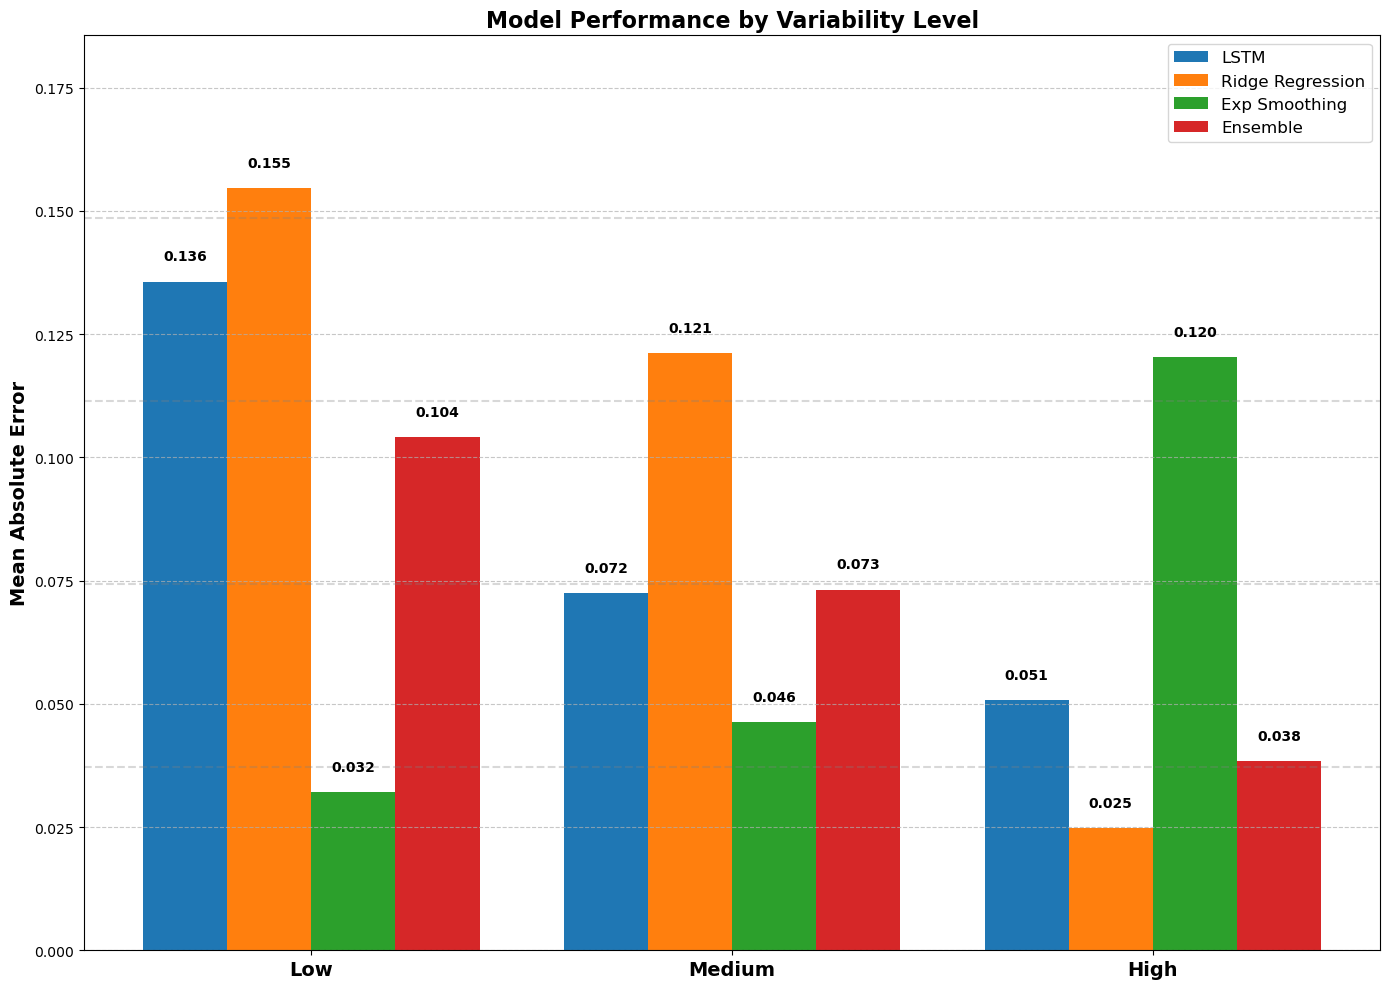

Zoomed MAE comparison plot saved to ./results/mae_comparison_zoomed_20250509_182410.png


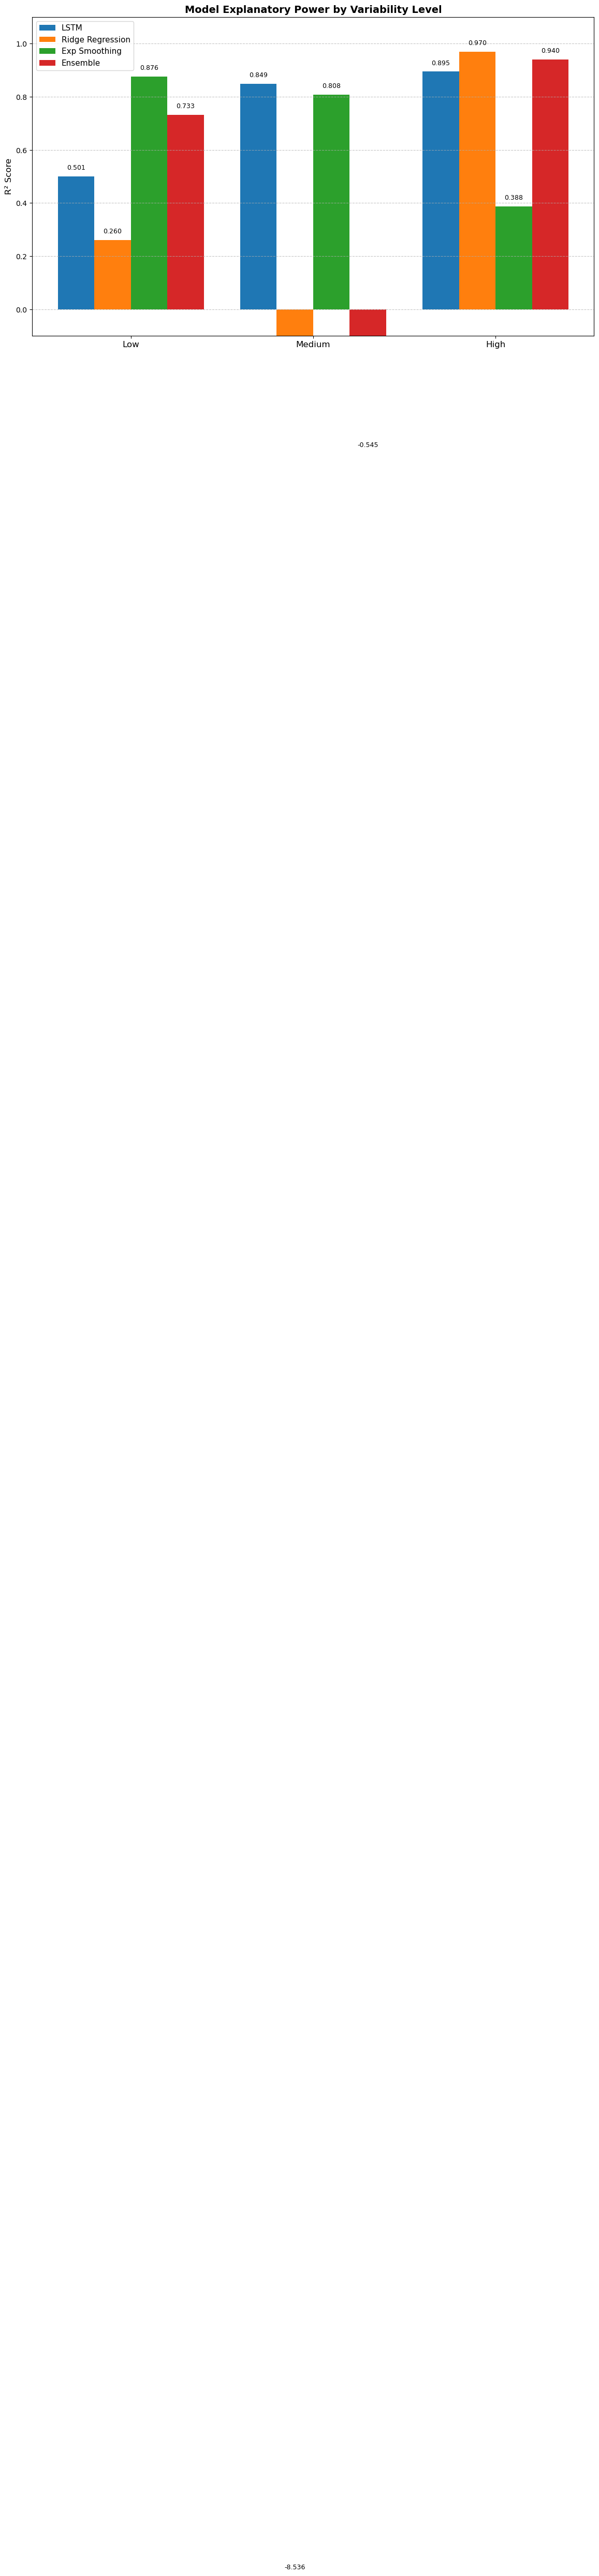

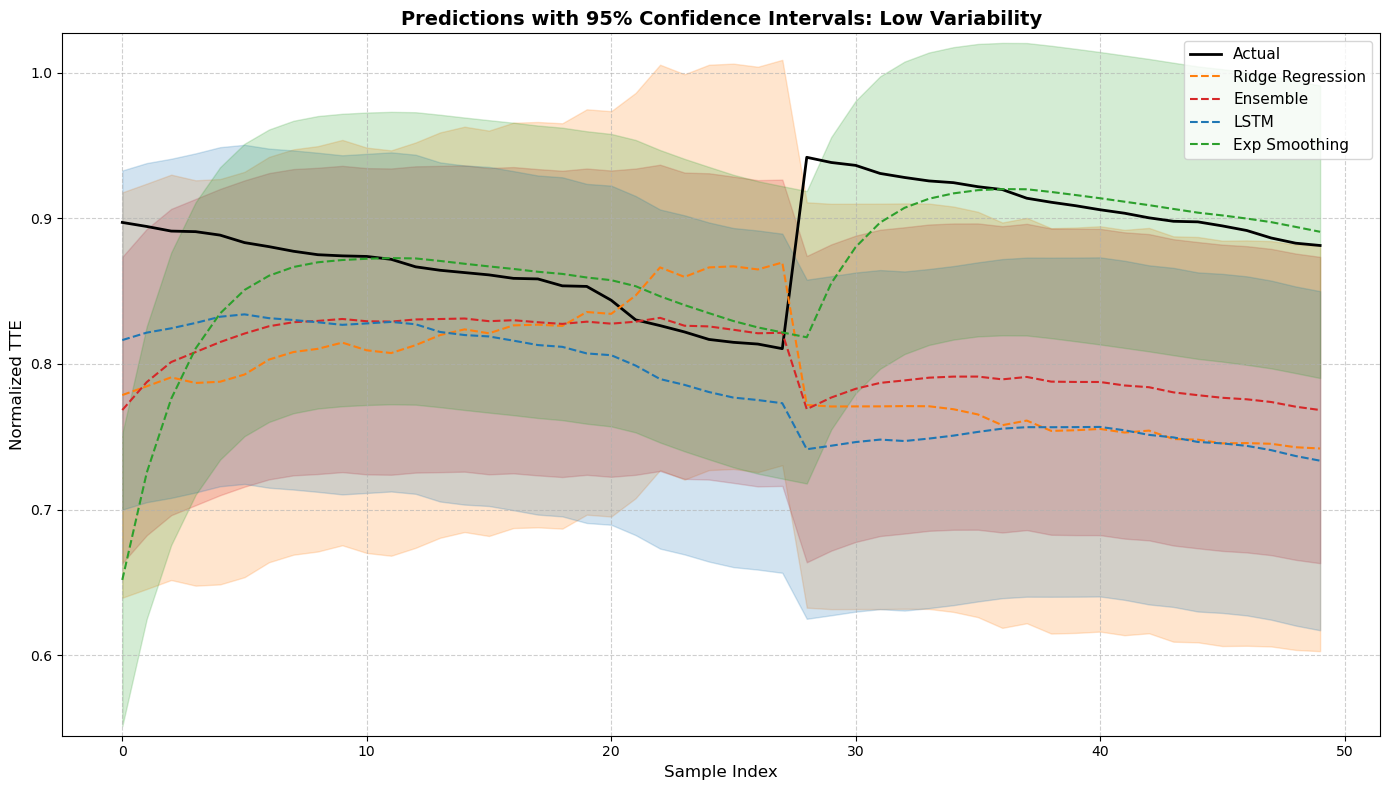

No prediction data available for error plot in low scenario


<Figure size 1400x800 with 0 Axes>

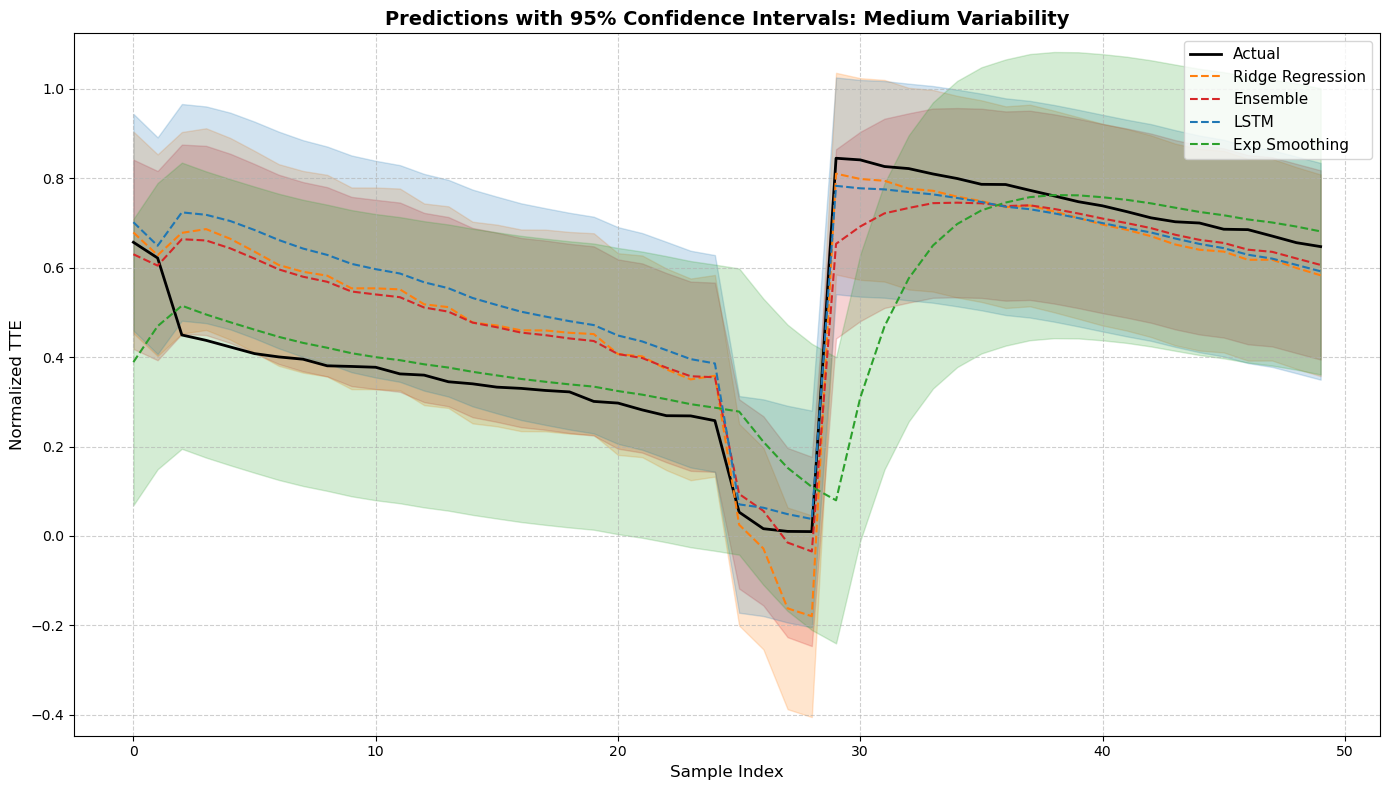

No prediction data available for error plot in medium scenario


<Figure size 1400x800 with 0 Axes>

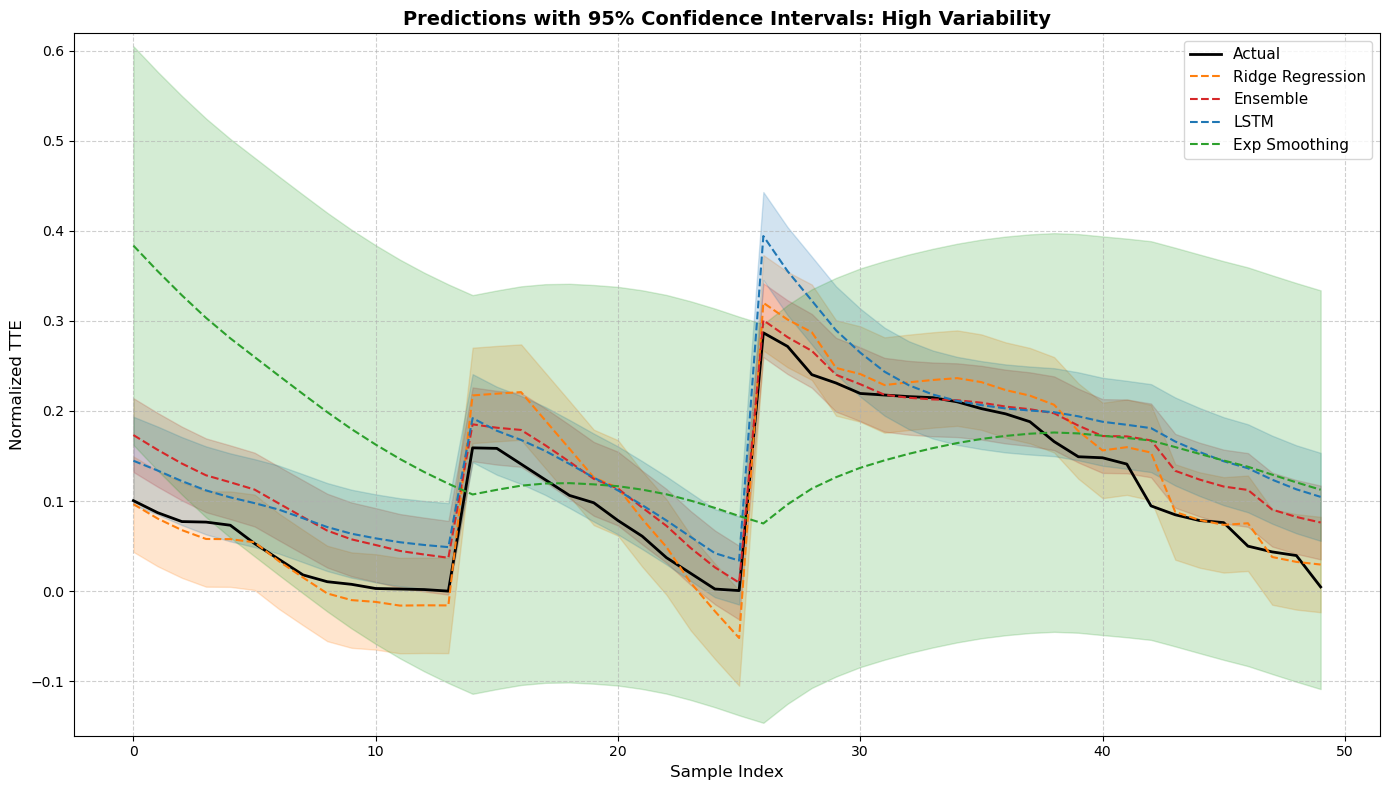

No prediction data available for error plot in high scenario


<Figure size 1400x800 with 0 Axes>

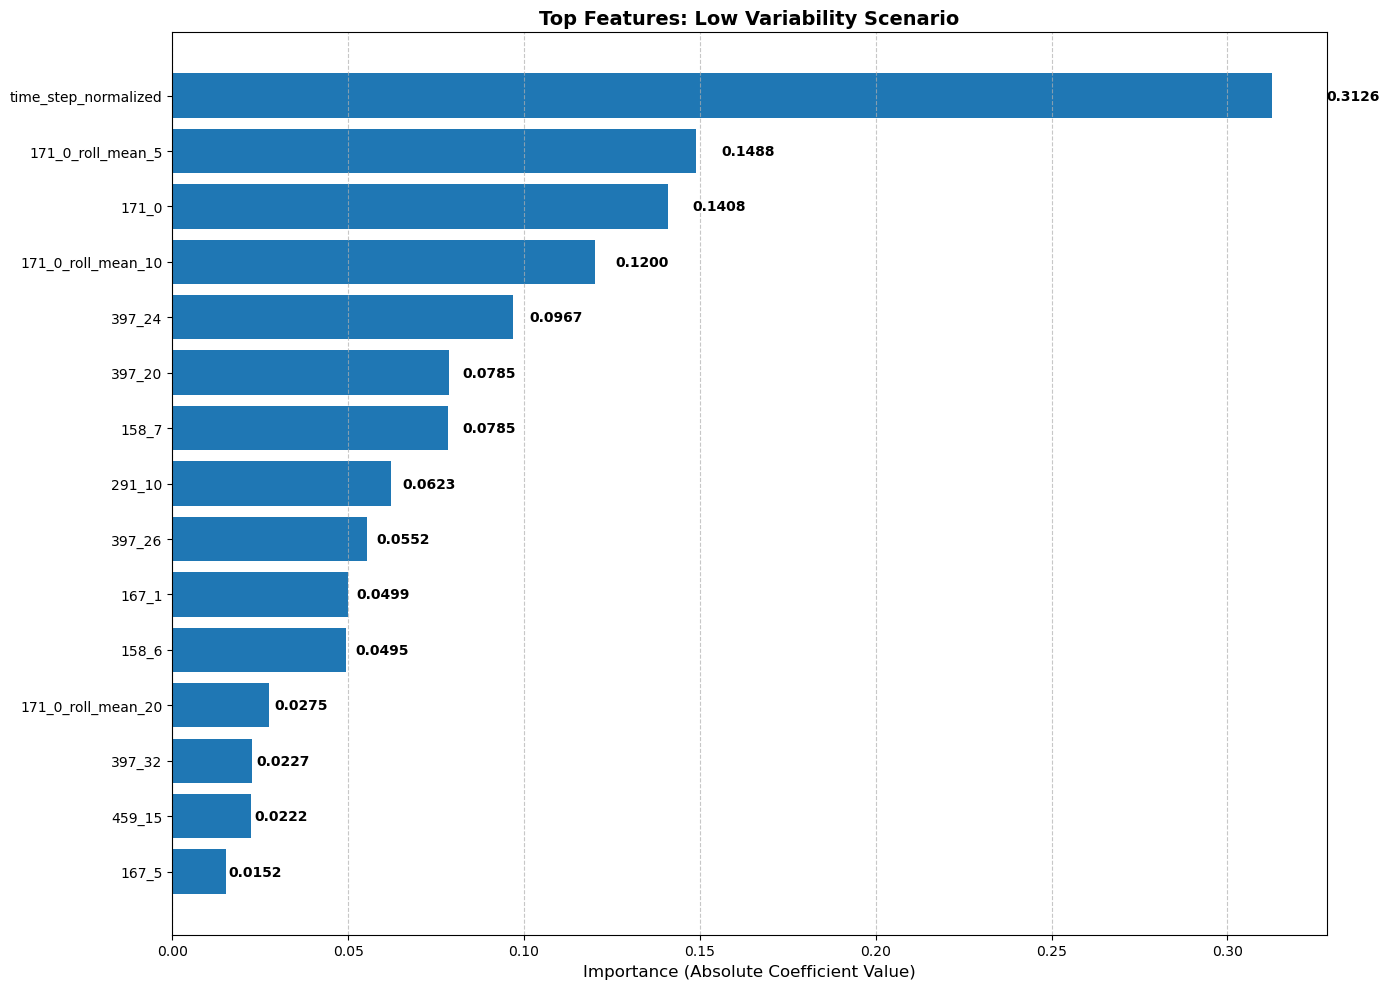

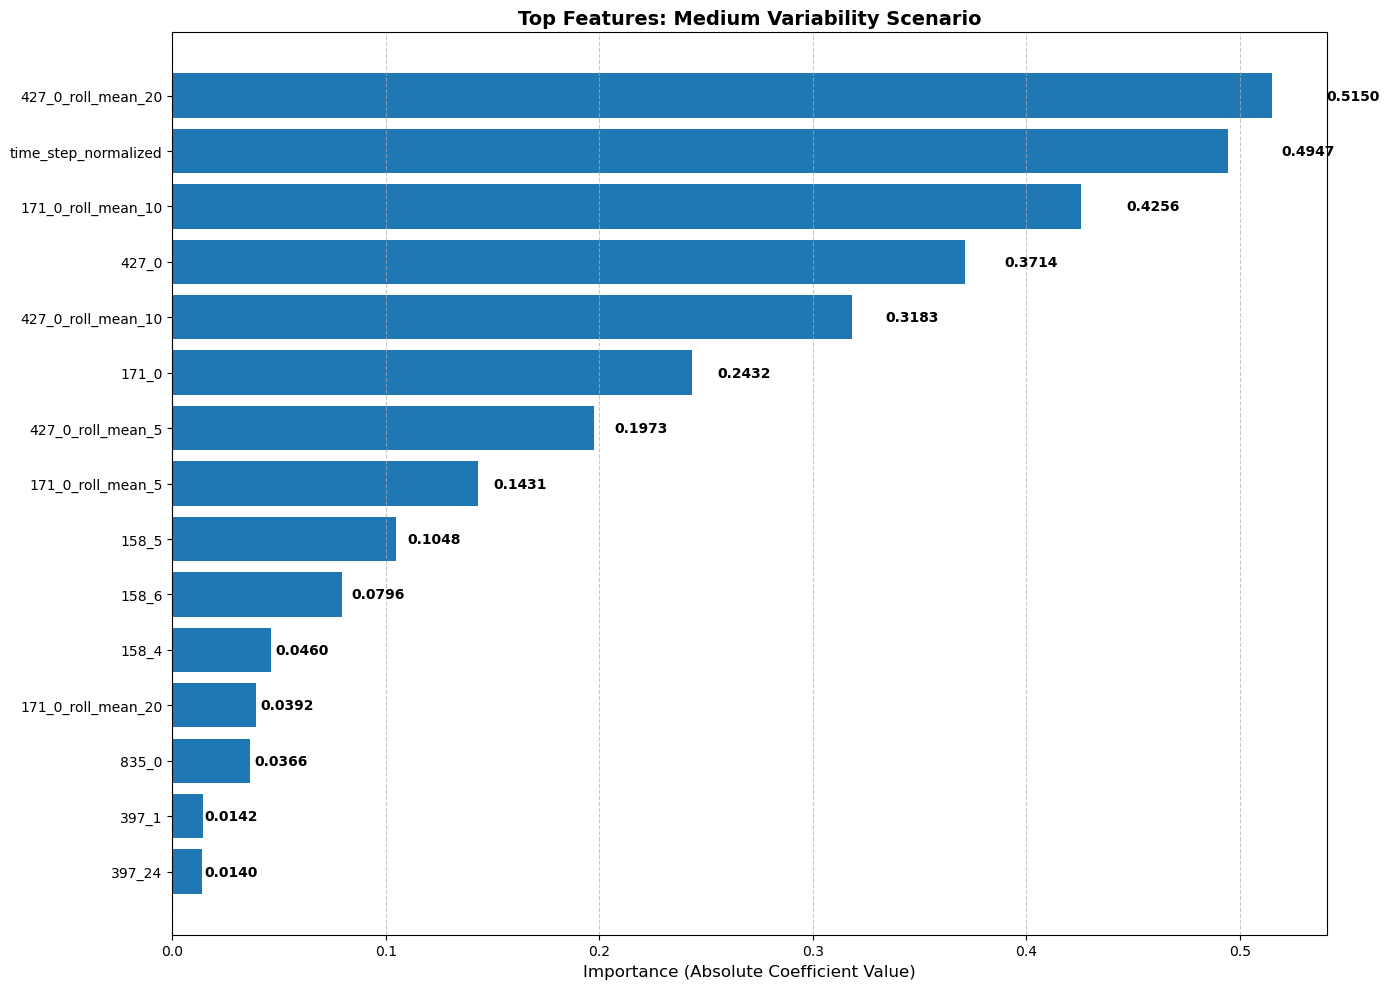

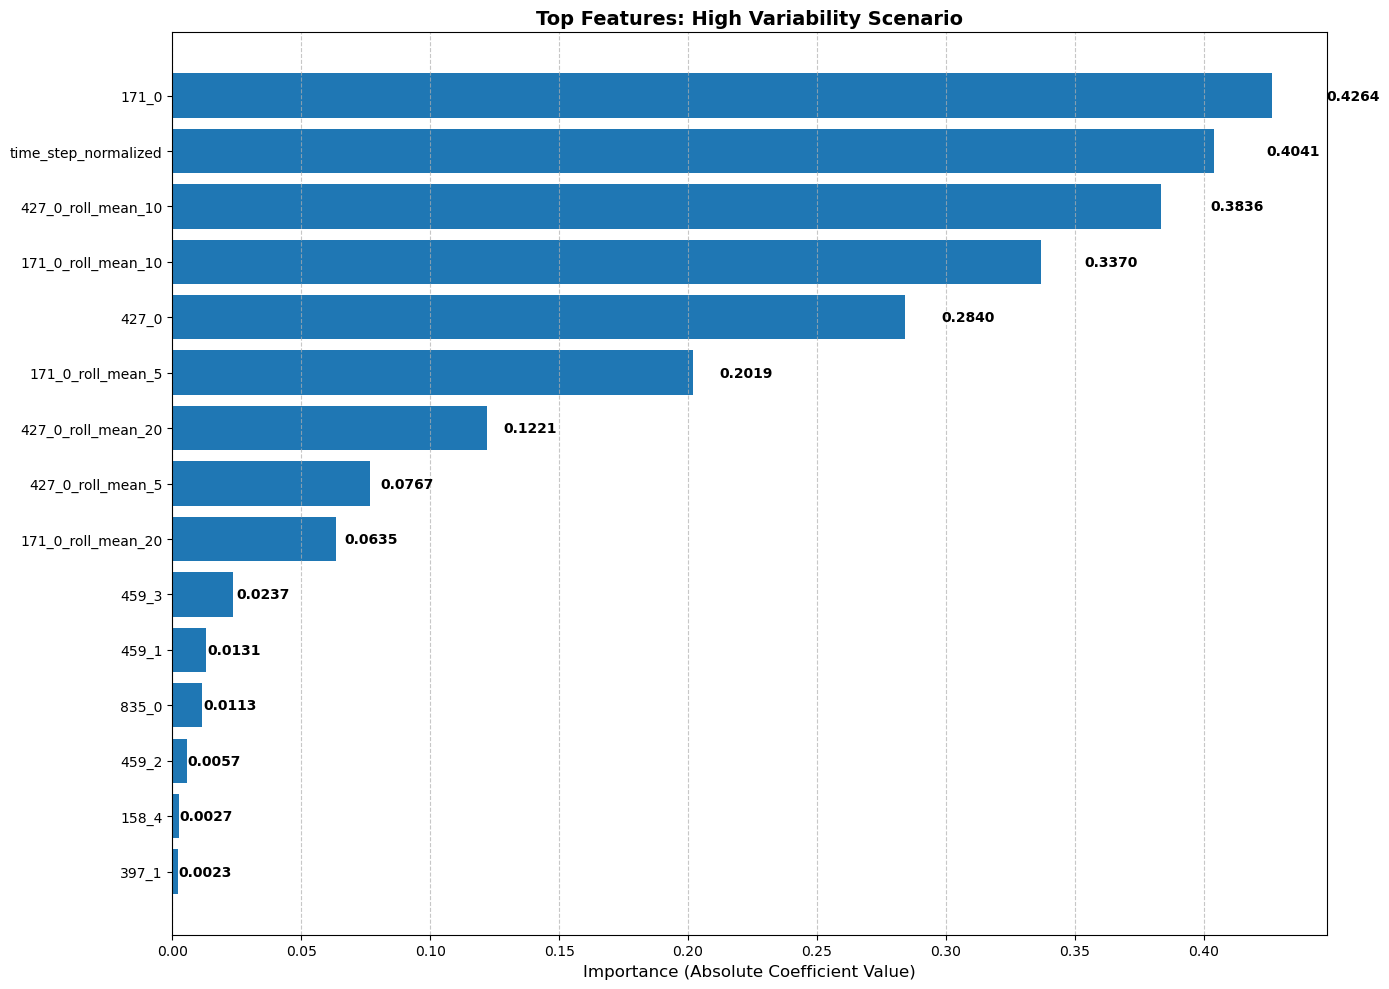


Performance Summary:
Scenario  LSTM MAE  LSTM R²  Ridge MAE  Ridge R²   ES MAE    ES R²  Ensemble MAE  Ensemble R²
     Low  0.135634 0.500508   0.154691  0.260234 0.032016 0.875681      0.104112     0.732812
  Medium  0.072427 0.848557   0.121147 -8.535544 0.046316 0.808058      0.073188    -0.544965
    High  0.050757 0.894553   0.024803  0.969821 0.120273 0.387681      0.038422     0.940210
Performance summary saved to ./results/performance_summary_20250509_182410.csv

--- MODEL SELECTION GUIDELINES ---

For Low Variability Scenario:
  Recommended Model: Exponential Smoothing
  MAE: 0.0320

For Medium Variability Scenario:
  Recommended Model: Exponential Smoothing
  MAE: 0.0463

For High Variability Scenario:
  Recommended Model: Ridge Regression
  MAE: 0.0248
  Top 3 Predictive Features:
    - 171_0: 0.4264
    - time_step_normalized: 0.4041
    - 427_0_roll_mean_10: 0.3836
Saved comparison table to ./metrics_20250509_182410/model_comparison_report/model_comparison_table.csv
Save

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Missing required metrics: ['Memory_increase']


posx and posy should be finite values



===== RESOURCE USAGE SUMMARY =====

total_execution:
  Duration: 202.9792 seconds
  Memory increase: 761.68 MB
  Final memory: 1678.70 MB

data_loading_preprocessing:
  Duration: 2.3104 seconds
  Memory increase: 50.59 MB
  Final memory: 967.61 MB

cleaning_preprocessing:
  Duration: 31.4229 seconds
  Memory increase: 123.50 MB
  Final memory: 1091.11 MB

feature_engineering_preprocessing:
  Duration: 3.8700 seconds
  Memory increase: 0.12 MB
  Final memory: 1091.23 MB

Analysis complete.
Results saved to: ./results
Metrics saved to: ./metrics_20250509_182410
Paper figures saved to: ./paper_figures_20250509_182410
Paper summary generated: tte_prediction_paper_findings.md


posx and posy should be finite values


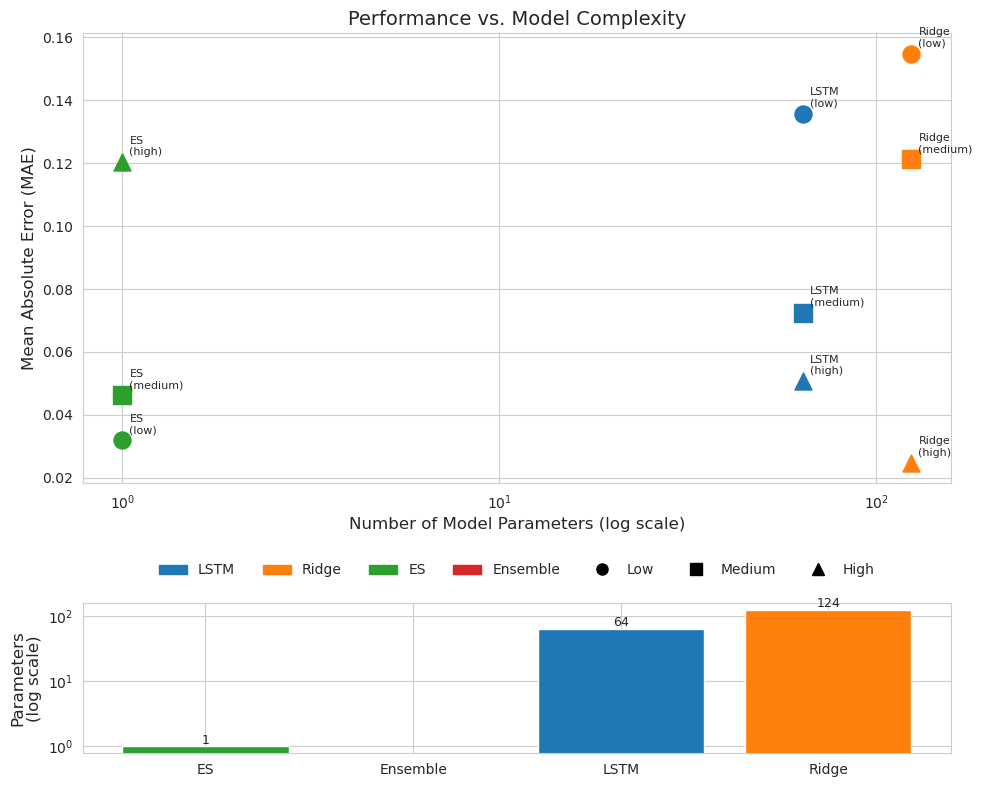

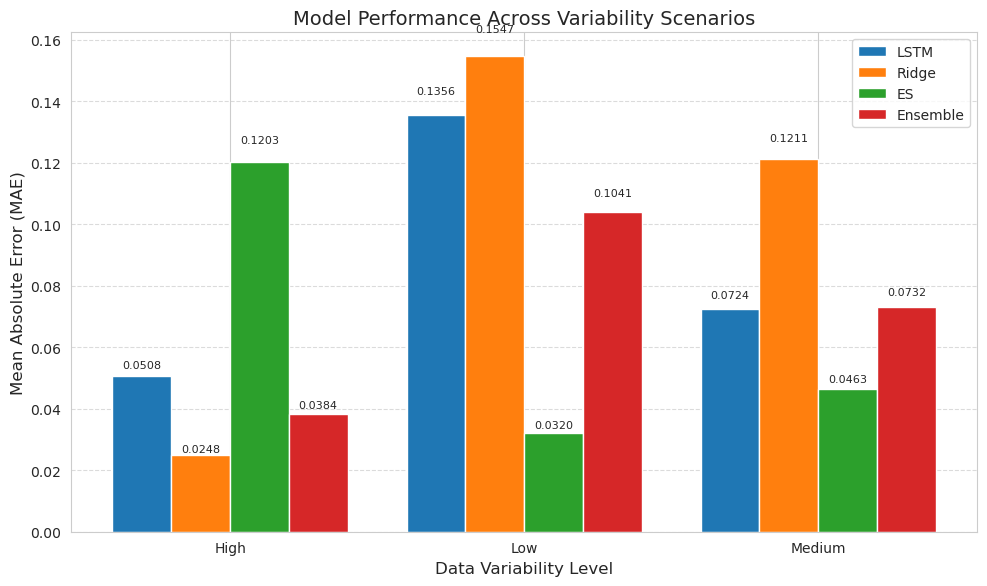

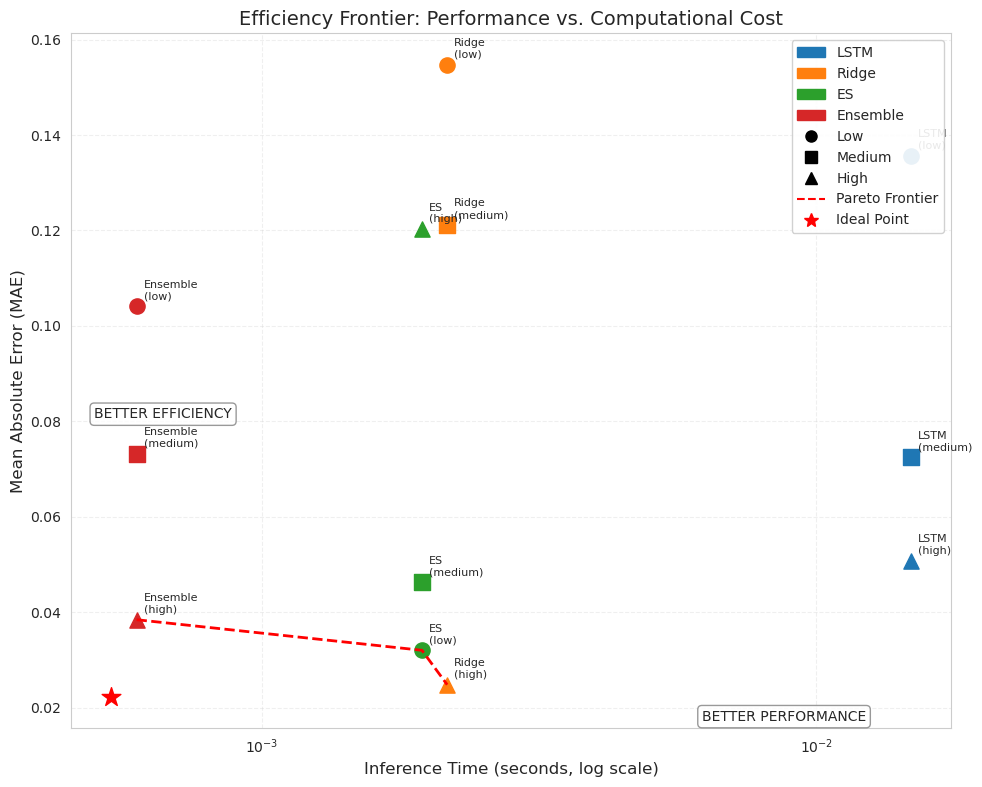

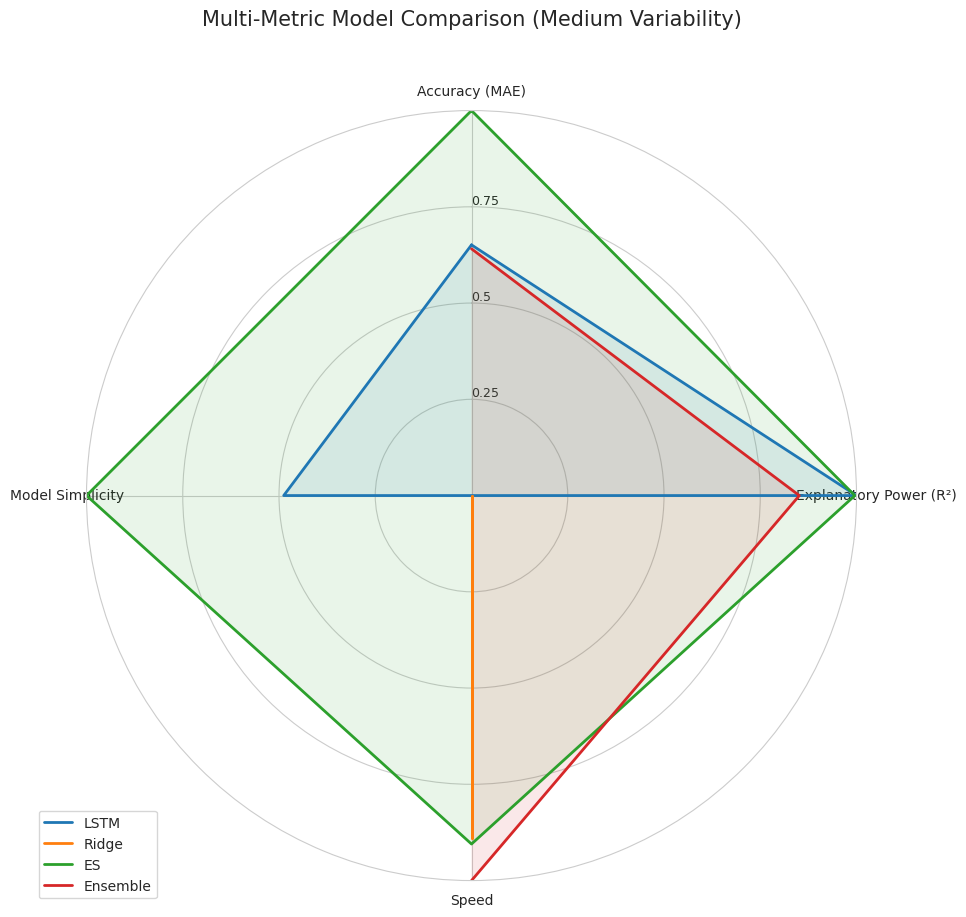

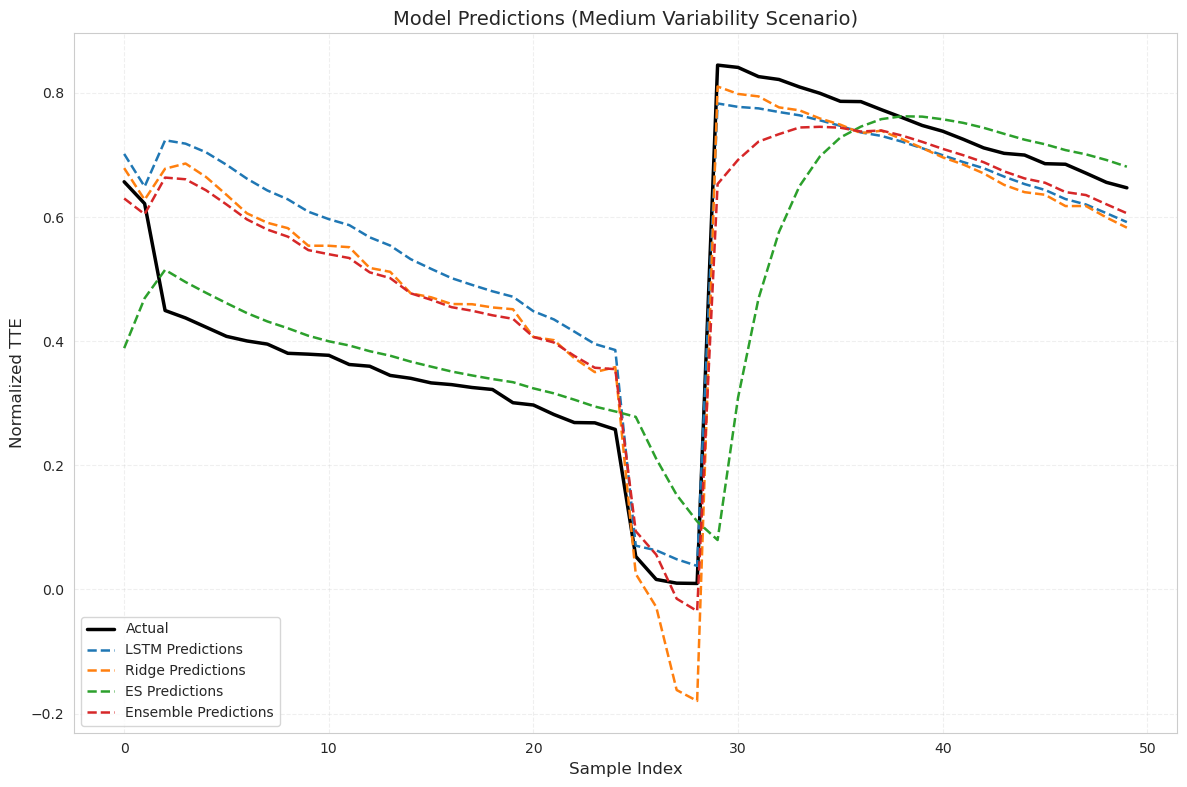

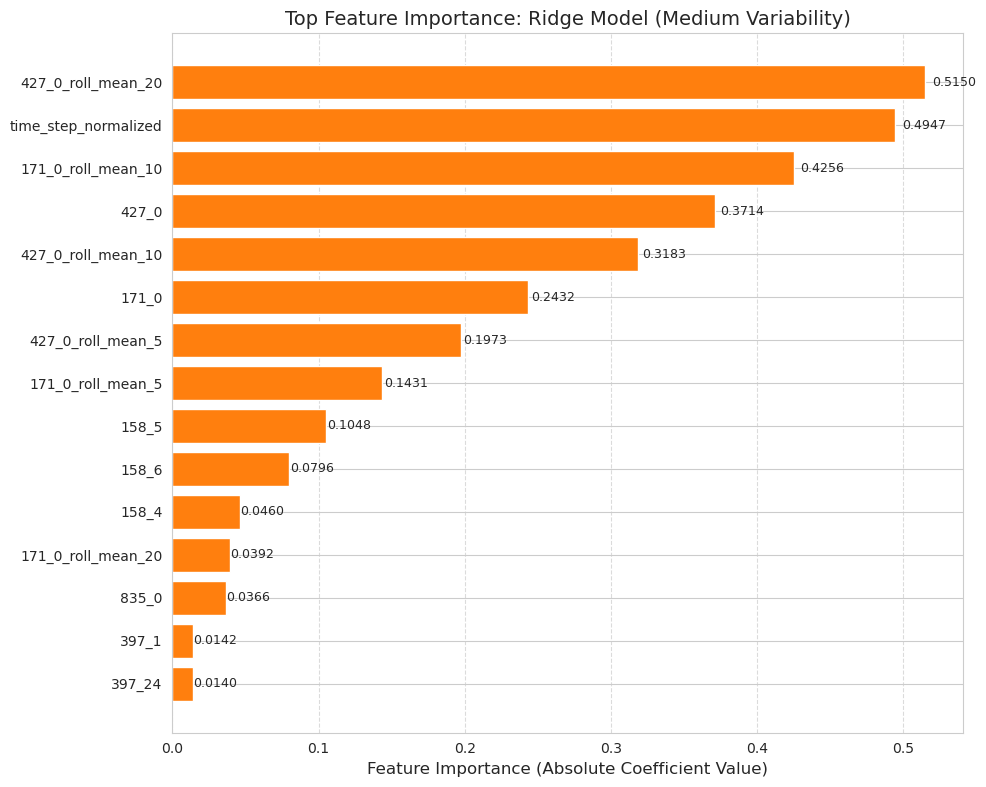

In [9]:
# Run the enhanced pipeline
predictor, model_comparison, figures = run_tte_prediction_with_metrics(
    './2241data/train_operational_readouts.csv',
    './2241data/train_tte.csv',
    config_path=None  # Or provide a path to your config file
)

# Generate paper summary
from integration_example import generate_paper_summary
summary_file = generate_paper_summary(predictor, "tte_prediction_paper_findings.md")